## 1. Import Required Libraries

In [22]:
import kagglehub
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, roc_auc_score, mean_absolute_error

## 2. Load Dataset

In [23]:
# Download dataset
path = kagglehub.dataset_download("nicolaswattiez/skillbuilder-data-2009-2010")
print("Path to dataset files:", path)

DATA_DIR = Path(path)
csvs = list(DATA_DIR.rglob("*.csv"))
print(f"Found {len(csvs)} CSV files")

# Load the data
df = pd.read_csv(csvs[0])
print(f"Original dataset shape: {df.shape}")
df.head()

Path to dataset files: C:\Users\Donna\.cache\kagglehub\datasets\nicolaswattiez\skillbuilder-data-2009-2010\versions\4
Found 1 CSV files
Original dataset shape: (6123270, 35)
Original dataset shape: (6123270, 35)


,problem_log_id,skill,problem_id,user_id,assignment_id,assistment_id,start_time,end_time,problem_type,original,...,overlap_time,template_id,answer_id,answer_text,first_action,problemlogid,Average_confidence(FRUSTRATED),Average_confidence(CONFUSED),Average_confidence(CONCENTRATING),Average_confidence(BORED)
0,137792159,NaN,557460,61394,565736,341511,2012-09-28 15:11:27,2012-09-28 15:11:36.856,choose_1,1,...,9852,341511,NaN,she,0,137792159,0.361323,0.0,0.336529,0.000000
1,138083797,Rounding,365981,61394,573819,204043,2012-10-09 11:01:52,2012-10-09 11:02:13.182,algebra,1,...,21175,204043,NaN,74.29,0,138083797,0.361323,0.0,0.766925,0.000000
2,142332619,Multiplication and Division Integers,426415,61394,734130,247525,2013-03-07 10:53:20,2013-03-07 10:53:28.661,algebra,1,...,8645,247525,NaN,00,0,142332619,0.361323,0.0,0.766925,0.442968
3,145939397,Proportion,86686,61394,821352,48081,2013-08-20 19:54:56,2013-08-20 19:55:21.753,algebra,1,...,25728,46362,NaN,3.8,0,145939397,0.775000,0.0,0.766925,0.912281
4,137111284,NaN,399669,76592,557216,227869,2012-09-10 17:20:10,2012-09-10 17:24:56.579,choose_1,1,...,286578,227869,NaN,C (wr - 1)(wr + 1),0,137111284,0.361323,0.0,0.766925,0.000000


## 3. Preprocess Data

In [24]:
# Rename columns to match our schema
work = df.rename(columns={
    "user_id": "student_id",
    "skill_id": "skill_id",
    "correct": "is_correct",
    "start_time": "timestamp"
})

work = work[["student_id", "skill_id", "is_correct", "timestamp"]]
work["is_correct"] = work["is_correct"].astype(int)

# Sort by student, skill, and time
work = work.sort_values(by=["student_id", "skill_id", "timestamp"])

print(f"Preprocessed data shape: {work.shape}")
work.head(10)

Preprocessed data shape: (6123270, 4)


,student_id,skill_id,is_correct,timestamp
3276993,21421,103.0,1,2013-06-05 13:00:06
4305094,21421,103.0,1,2013-06-05 13:00:14
3515970,21421,103.0,1,2013-06-05 13:00:22
2416143,21421,277.0,1,2013-06-05 13:00:39
1315405,21421,277.0,1,2013-06-05 13:00:45
3647040,21421,277.0,1,2013-06-05 13:00:50
968401,21421,311.0,0,2013-05-22 14:44:20
47925,21421,NaN,0,2013-05-22 14:57:15
5084076,21421,NaN,1,2013-05-22 14:58:06
4137747,21421,NaN,0,2013-05-22 14:58:30


## 4. Filter and Split Data

In [25]:
# Count attempts per (student, skill)
counts = (
    work.groupby(["student_id", "skill_id"])
        .size()
        .rename("n_attempts")
)

work = work.join(counts, on=["student_id", "skill_id"])

# Filter for sequences with at least 4 attempts
filtered = work[work["n_attempts"] >= 4].copy()
print(f"Filtered data shape (>=4 attempts): {filtered.shape}")

# Add attempt index
filtered["attempt_idx"] = (
    filtered.groupby(["student_id", "skill_id"])
            .cumcount() + 1
)

filtered["max_idx"] = (
    filtered.groupby(["student_id", "skill_id"])["attempt_idx"]
            .transform("max")
)

# Split: train = all but last attempt, test = last attempt
train = filtered[filtered["attempt_idx"] < filtered["max_idx"]]
test  = filtered[filtered["attempt_idx"] == filtered["max_idx"]]

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
test.head()

Filtered data shape (>=4 attempts): (2379075, 5)
Train shape: (2183373, 7)
Test shape: (195702, 7)
Train shape: (2183373, 7)
Test shape: (195702, 7)


,student_id,skill_id,is_correct,timestamp,n_attempts,attempt_idx,max_idx
4065965,24586,85.0,1,2012-10-29 20:11:46,4.0,4,4
2451929,26046,75.0,1,2013-05-01 15:26:34,8.0,8,8
4042236,52535,25.0,1,2013-04-09 07:35:21,10.0,10,10
1267476,52535,314.0,1,2013-04-05 07:37:26,6.0,6,6
4951385,52535,359.0,0,2013-06-04 14:20:35,4.0,4,4


## 5. Define iBKT Algorithm



In [26]:
def clamp(x, min_val=0.0, max_val=1.0):
    """Clamp value to range [min_val, max_val]"""
    return max(min_val, min(max_val, x))

def ibkt_update(K_old, ability, correctness, alpha=0.45):
    """
    Update mastery using iBKT algorithm.
    
    Args:
        K_old: Previous mastery level [0, 1]
        ability: Student's global ability [0, 1]
        correctness: 1 if correct, 0 if incorrect
        alpha: Learning rate for mastery update
    
    Returns:
        K_new: Updated mastery level
    """
    # Personalized prior
    prior = 0.7 * K_old + 0.3 * ability
    
    # EMA update
    K_new = (1 - alpha) * prior + alpha * correctness
    
    # Clamp to valid range
    K_new = clamp(K_new, 0.0, 1.0)
    
    return K_new

def update_ability(ability_old, session_accuracy, beta=0.20):
    """
    Update global ability using EMA.
    
    Args:
        ability_old: Previous ability score
        session_accuracy: Accuracy in current session
        beta: Learning rate for ability update
    
    Returns:
        ability_new: Updated ability score
    """
    ability_new = (1 - beta) * ability_old + beta * session_accuracy
    return clamp(ability_new, 0.05, 0.95)

## 6. Train iBKT Model

In [27]:
# Initialize hyperparameters
ALPHA = 0.45  # Mastery learning rate
BETA = 0.20   # Ability learning rate
INITIAL_MASTERY = 0.0   # Starting mastery for new skills
INITIAL_ABILITY = 0.5   # Starting ability for new students

# Track mastery per (student, skill)
mastery = {}

# Track ability per student
student_ability = {}

print("Training iBKT model with session-based ability updates...")

# Group training data by student and skill to simulate sessions
from itertools import groupby

train_sorted = train.sort_values(['student_id', 'skill_id', 'timestamp'])

# Process each (student, skill) sequence as a session
for (student_id, skill_id), group in train_sorted.groupby(['student_id', 'skill_id']):
    key = (student_id, skill_id)
    
    # Get current ability at start of session
    ability = student_ability.get(student_id, INITIAL_ABILITY)
    
    # Track session performance
    session_correct = 0
    session_total = 0
    
    # Process each attempt in this session
    for r in group.itertuples(index=False):
        is_correct = r.is_correct
        
        # Get current mastery
        K_old = mastery.get(key, INITIAL_MASTERY)
        
        # Update mastery using iBKT with personalized prior
        K_new = ibkt_update(K_old, ability, is_correct, ALPHA)
        mastery[key] = K_new
        
        # Track for session-level ability update
        session_correct += is_correct
        session_total += 1
    
    # Update ability after this session (EMA based on session accuracy)
    if session_total > 0:
        session_accuracy = session_correct / session_total
        ability_new = update_ability(ability, session_accuracy, BETA)
        student_ability[student_id] = ability_new

print(f"Trained on {len(train)} attempts")
print(f"Tracked {len(mastery)} (student, skill) pairs")
print(f"Tracked {len(student_ability)} students")
print(f"Ability range: [{min(student_ability.values()):.3f}, {max(student_ability.values()):.3f}]")

Training iBKT model with session-based ability updates...
Trained on 2183373 attempts
Tracked 195702 (student, skill) pairs
Tracked 24270 students
Ability range: [0.050, 0.950]
Trained on 2183373 attempts
Tracked 195702 (student, skill) pairs
Tracked 24270 students
Ability range: [0.050, 0.950]


## 7. Generate Predictions on Test Set

In [28]:
# Generate predictions using both mastery AND ability
y_true = []
y_pred = []

print("Generating predictions on test set...")
for r in test.itertuples(index=False):
    student_id = r.student_id
    skill_id = r.skill_id
    is_correct = r.is_correct
    
    key = (student_id, skill_id)
    
    # Get mastery from training (or use initial if not seen)
    K = mastery.get(key, INITIAL_MASTERY)
    
    # Get student ability (or use initial if not seen)
    ability = student_ability.get(student_id, INITIAL_ABILITY)
    
    # Compute personalized prior as prediction
    # This matches how iBKT uses prior = 0.7*K + 0.3*ability
    p_correct = 0.7 * K + 0.3 * ability
    
    y_true.append(is_correct)
    y_pred.append(p_correct)

print(f"Generated {len(y_pred)} predictions")
print(f"Mean predicted probability: {np.mean(y_pred):.4f}")
print(f"Actual accuracy: {np.mean(y_true):.4f}")

Generating predictions on test set...
Generated 195702 predictions
Mean predicted probability: 0.7237
Actual accuracy: 0.8317
Generated 195702 predictions
Mean predicted probability: 0.7237
Actual accuracy: 0.8317


### Visualize Ability Distribution

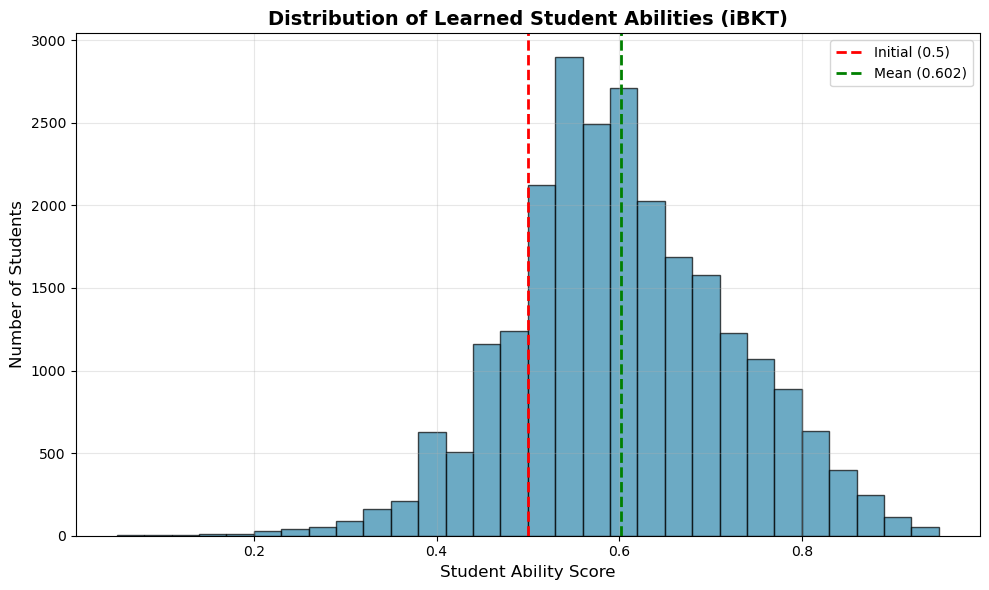

Ability Statistics:
  Min:    0.0500
  Max:    0.9500
  Mean:   0.6024
  Median: 0.5973
  Std:    0.1195


In [29]:
# Plot distribution of learned student abilities
plt.figure(figsize=(10, 6))
ability_values = list(student_ability.values())
plt.hist(ability_values, bins=30, edgecolor='black', alpha=0.7, color='#2E86AB')
plt.axvline(INITIAL_ABILITY, color='red', linestyle='--', linewidth=2, label=f'Initial ({INITIAL_ABILITY})')
plt.axvline(np.mean(ability_values), color='green', linestyle='--', linewidth=2, label=f'Mean ({np.mean(ability_values):.3f})')
plt.xlabel('Student Ability Score', fontsize=12)
plt.ylabel('Number of Students', fontsize=12)
plt.title('Distribution of Learned Student Abilities (iBKT)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Ability Statistics:")
print(f"  Min:    {min(ability_values):.4f}")
print(f"  Max:    {max(ability_values):.4f}")
print(f"  Mean:   {np.mean(ability_values):.4f}")
print(f"  Median: {np.median(ability_values):.4f}")
print(f"  Std:    {np.std(ability_values):.4f}")

## 8. Model Evaluation: Predictive Validity and Internal Consistency



In [30]:
# Calculate metrics
# Primary metric: MAE on last question (per student-skill sequence)
mae = mean_absolute_error(y_true, y_pred)

# Correlation between predicted and actual
correlation = np.corrcoef(y_pred, y_true)[0, 1]

# Additional metrics
logloss = log_loss(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

print("=" * 60)
print("iBKT Model Performance (Last Question Predictions)")
print("=" * 60)
print(f"MAE (Primary):        {mae:.4f}")
print(f"Correlation:          {correlation:.4f}")
print("-" * 60)
print(f"Log Loss:             {logloss:.4f}")
print(f"AUC:                  {auc:.4f}")
print("=" * 60)

# Create results dataframe for comparison
results = {
    "Metric": ["MAE", "Correlation", "Log Loss", "AUC"],
    "iBKT": [mae, correlation, logloss, auc]
}
results_df = pd.DataFrame(results)
results_df

iBKT Model Performance (Last Question Predictions)
MAE (Primary):        0.2899
Correlation:          0.4666
------------------------------------------------------------
Log Loss:             0.4050
AUC:                  0.7720


,Metric,iBKT
0,MAE,0.289866
1,Correlation,0.466598
2,Log Loss,0.404972
3,AUC,0.772013


## 9. Calibration Plot

This plot shows how well-calibrated the model is by comparing predicted probabilities to observed accuracy.

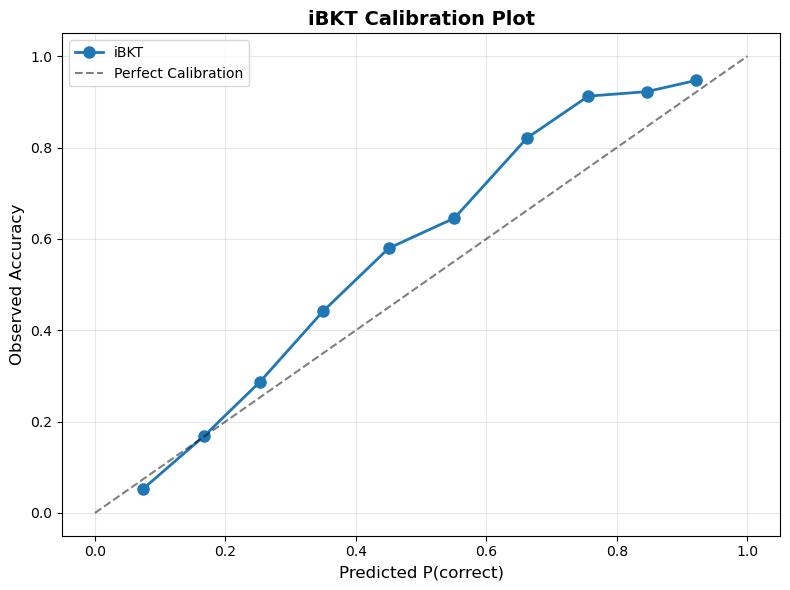

In [31]:
# Create calibration plot
bins = np.linspace(0, 1, 11)
bin_ids = np.digitize(y_pred, bins) - 1

px, py = [], []
for b in range(10):
    mask = bin_ids == b
    if mask.sum() == 0:
        continue
    px.append(np.mean(np.array(y_pred)[mask]))
    py.append(np.mean(np.array(y_true)[mask]))

plt.figure(figsize=(8, 6))
plt.plot(px, py, marker="o", linewidth=2, markersize=8, label="iBKT")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Perfect Calibration")
plt.xlabel("Predicted P(correct)", fontsize=12)
plt.ylabel("Observed Accuracy", fontsize=12)
plt.title("iBKT Calibration Plot", fontsize=14, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

---

## 11. Standard BKT Baseline (for comparison)

Now we'll run standard BKT on the same train/test split to ensure fair comparison.

### Define Standard BKT Algorithm

In [32]:
def bkt_step(pL, correct, slip=0.1, guess=0.2, learn=0.15):
    """
    Standard BKT update step.
    
    Args:
        pL: Current probability of mastery
        correct: 1 if correct, 0 if incorrect
        slip: Probability of slip (know but answer wrong)
        guess: Probability of guess (don't know but answer right)
        learn: Probability of learning after this step
    
    Returns:
        p_correct: Predicted probability of correct answer
        pL_next: Updated probability of mastery
    """
    p_correct = pL*(1-slip) + (1-pL)*guess

    if correct == 1:
        pL_post = (pL*(1-slip)) / (p_correct + 1e-12)
    else:
        pL_post = (pL*slip) / ((1-p_correct) + 1e-12)

    pL_next = pL_post + (1 - pL_post)*learn
    return p_correct, pL_next

### Train Standard BKT

In [33]:
# Standard BKT parameters
P_L0 = 0.2  # Initial mastery probability
bkt_mastery = {}

print("Training Standard BKT model...")
for r in train.itertuples(index=False):
    key = (r.student_id, r.skill_id)
    pL = bkt_mastery.get(key, P_L0)
    _, pL_next = bkt_step(pL, r.is_correct)
    bkt_mastery[key] = pL_next

print(f"Trained on {len(train)} attempts")
print(f"Tracked {len(bkt_mastery)} (student, skill) pairs")

Training Standard BKT model...
Trained on 2183373 attempts
Tracked 195702 (student, skill) pairs
Trained on 2183373 attempts
Tracked 195702 (student, skill) pairs


### Generate BKT Predictions

In [34]:
bkt_y_true, bkt_y_pred = [], []

print("Generating BKT predictions on test set...")
for r in test.itertuples(index=False):
    pL = bkt_mastery.get((r.student_id, r.skill_id), P_L0)
    # P(correct) = P(learned)*(1-slip) + P(not learned)*guess
    p_pred = pL*(1-0.1) + (1-pL)*0.2
    bkt_y_true.append(r.is_correct)
    bkt_y_pred.append(p_pred)

print(f"Generated {len(bkt_y_pred)} predictions")
print(f"Mean predicted probability: {np.mean(bkt_y_pred):.4f}")
print(f"Actual accuracy: {np.mean(bkt_y_true):.4f}")

Generating BKT predictions on test set...
Generated 195702 predictions
Mean predicted probability: 0.8154
Actual accuracy: 0.8317
Generated 195702 predictions
Mean predicted probability: 0.8154
Actual accuracy: 0.8317


### Evaluate Standard BKT Performance

In [35]:
# Calculate BKT metrics
# Primary metric: MAE on last question
bkt_mae = mean_absolute_error(bkt_y_true, bkt_y_pred)

# Correlation between predicted and actual
bkt_correlation = np.corrcoef(bkt_y_pred, bkt_y_true)[0, 1]

# Additional metrics
bkt_logloss = log_loss(bkt_y_true, bkt_y_pred)
bkt_auc = roc_auc_score(bkt_y_true, bkt_y_pred)

print("=" * 60)
print("Standard BKT Model Performance (Last Question Predictions)")
print("=" * 60)
print(f"MAE (Primary):        {bkt_mae:.4f}")
print(f"Correlation:          {bkt_correlation:.4f}")
print("-" * 60)
print(f"Log Loss:             {bkt_logloss:.4f}")
print(f"AUC:                  {bkt_auc:.4f}")
print("=" * 60)

Standard BKT Model Performance (Last Question Predictions)
MAE (Primary):        0.2383
Correlation:          0.4307
------------------------------------------------------------
Log Loss:             0.3841
AUC:                  0.7200


### BKT Calibration Plot

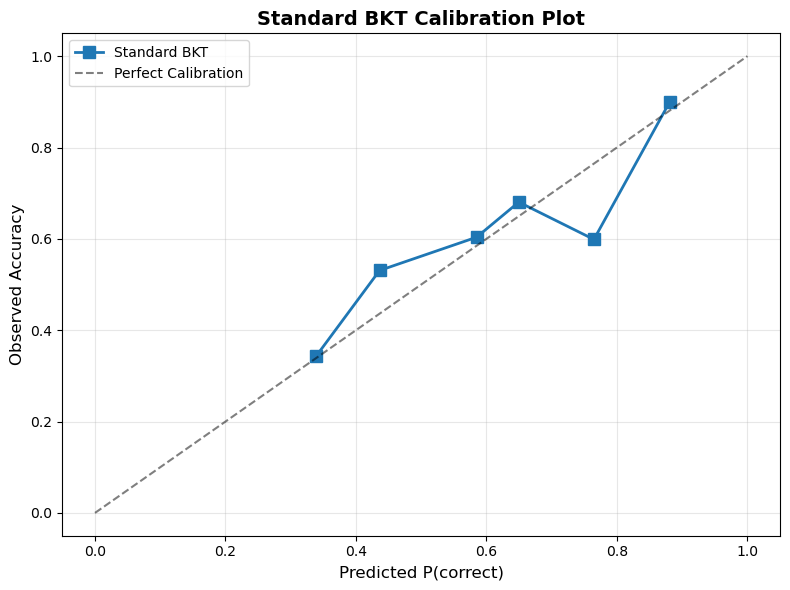

In [36]:
# Create BKT calibration plot
bkt_bins = np.linspace(0, 1, 11)
bkt_bin_ids = np.digitize(bkt_y_pred, bkt_bins) - 1

bkt_px, bkt_py = [], []
for b in range(10):
    mask = bkt_bin_ids == b
    if mask.sum() == 0:
        continue
    bkt_px.append(np.mean(np.array(bkt_y_pred)[mask]))
    bkt_py.append(np.mean(np.array(bkt_y_true)[mask]))

plt.figure(figsize=(8, 6))
plt.plot(bkt_px, bkt_py, marker="s", linewidth=2, markersize=8, label="Standard BKT")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Perfect Calibration")
plt.xlabel("Predicted P(correct)", fontsize=12)
plt.ylabel("Observed Accuracy", fontsize=12)
plt.title("Standard BKT Calibration Plot", fontsize=14, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

---

## 12. Comparative Analysis: Predictive Performance

### Overall Model Performance

Both models evaluated on identical held-out final attempts from student–skill sequences. Results reflect **algorithmic behavior** under standardized conditions, not educational effectiveness.

In [37]:
# Comparison table with actual BKT results from same train/test split
comparison = pd.DataFrame({
    "Metric": ["MAE (Primary)", "Correlation", "Log Loss", "AUC"],
    "Standard BKT": [bkt_mae, bkt_correlation, bkt_logloss, bkt_auc],
    "iBKT": [mae, correlation, logloss, auc],
    "Difference": [
        mae - bkt_mae,
        correlation - bkt_correlation,
        logloss - bkt_logloss,
        auc - bkt_auc
    ]
})

print("=" * 75)
print("Model Comparison: Standard BKT vs iBKT (Last Question Predictions)")
print("=" * 75)
print(comparison.to_string(index=False))
print("=" * 75)
print("\nInterpretation:")
print("  MAE:         Lower is better (negative difference favors iBKT)")
print("  Correlation: Higher is better (positive difference favors iBKT)")
print("  Log Loss:    Lower is better (negative difference favors iBKT)")
print("  AUC:         Higher is better (positive difference favors iBKT)")
print("=" * 75)

# Determine winner
if mae < bkt_mae:
    winner = "iBKT"
    mae_improvement = ((bkt_mae - mae) / bkt_mae) * 100
    print(f"\n✓ iBKT has {mae_improvement:.2f}% lower MAE (more accurate)")
else:
    winner = "Standard BKT"
    mae_improvement = ((mae - bkt_mae) / bkt_mae) * 100
    print(f"\n✓ Standard BKT has {mae_improvement:.2f}% lower MAE (more accurate)")

comparison

Model Comparison: Standard BKT vs iBKT (Last Question Predictions)
       Metric  Standard BKT     iBKT  Difference
MAE (Primary)      0.238305 0.289866    0.051561
  Correlation      0.430700 0.466598    0.035898
     Log Loss      0.384077 0.404972    0.020895
          AUC      0.720006 0.772013    0.052007

Interpretation:
  MAE:         Lower is better (negative difference favors iBKT)
  Correlation: Higher is better (positive difference favors iBKT)
  Log Loss:    Lower is better (negative difference favors iBKT)
  AUC:         Higher is better (positive difference favors iBKT)

✓ Standard BKT has 21.64% lower MAE (more accurate)


,Metric,Standard BKT,iBKT,Difference
0,MAE (Primary),0.238305,0.289866,0.051561
1,Correlation,0.430700,0.466598,0.035898
2,Log Loss,0.384077,0.404972,0.020895
3,AUC,0.720006,0.772013,0.052007


### Side-by-Side Calibration Comparison

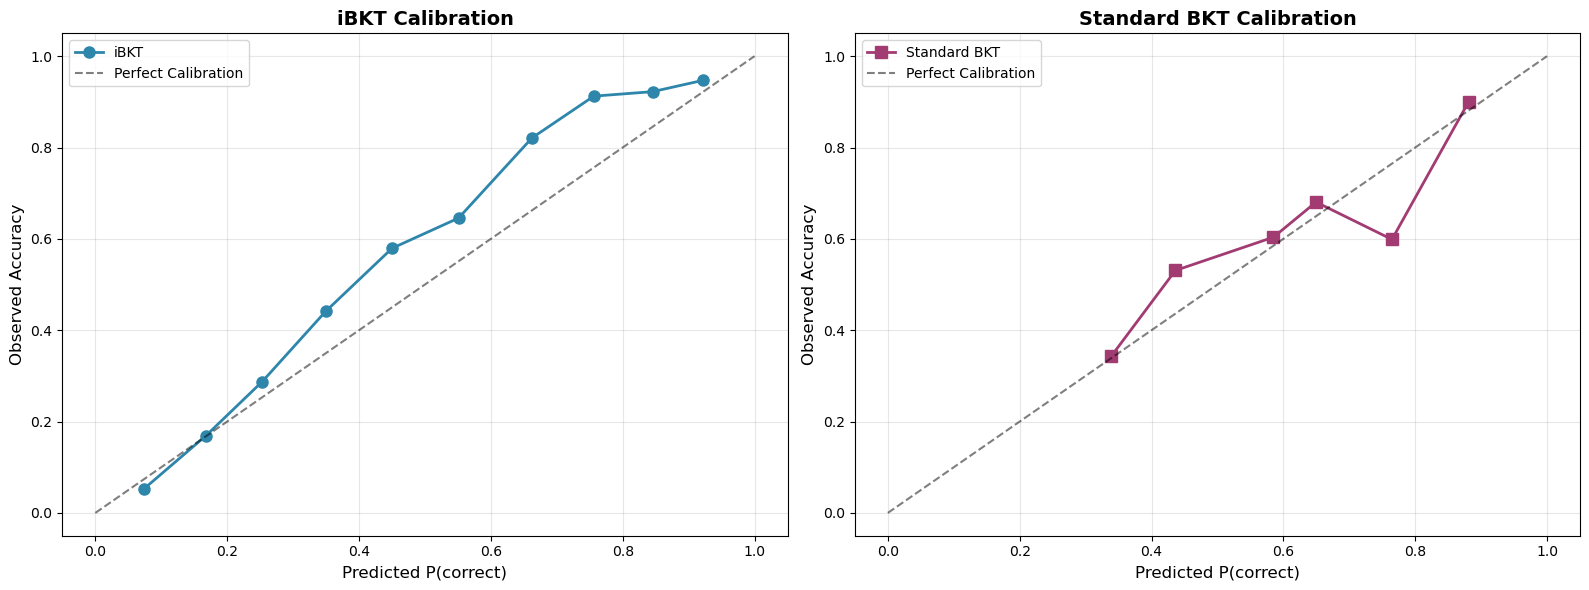

In [38]:
# Create side-by-side calibration plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# iBKT calibration
ax1.plot(px, py, marker="o", linewidth=2, markersize=8, label="iBKT", color="#2E86AB")
ax1.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Perfect Calibration")
ax1.set_xlabel("Predicted P(correct)", fontsize=12)
ax1.set_ylabel("Observed Accuracy", fontsize=12)
ax1.set_title("iBKT Calibration", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Standard BKT calibration
ax2.plot(bkt_px, bkt_py, marker="s", linewidth=2, markersize=8, label="Standard BKT", color="#A23B72")
ax2.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Perfect Calibration")
ax2.set_xlabel("Predicted P(correct)", fontsize=12)
ax2.set_ylabel("Observed Accuracy", fontsize=12)
ax2.set_title("Standard BKT Calibration", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

### Overlay Calibration Plot

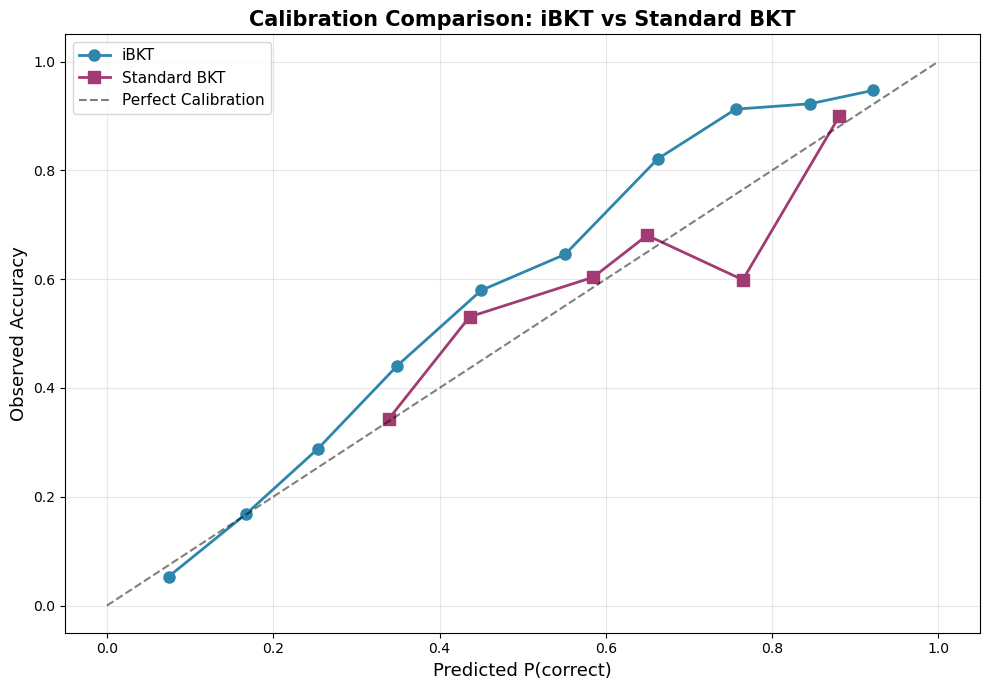

In [39]:
# Create overlay calibration plot
plt.figure(figsize=(10, 7))
plt.plot(px, py, marker="o", linewidth=2, markersize=8, label="iBKT", color="#2E86AB")
plt.plot(bkt_px, bkt_py, marker="s", linewidth=2, markersize=8, label="Standard BKT", color="#A23B72")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Perfect Calibration")
plt.xlabel("Predicted P(correct)", fontsize=13)
plt.ylabel("Observed Accuracy", fontsize=13)
plt.title("Calibration Comparison: iBKT vs Standard BKT", fontsize=15, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

### Predicted vs Actual Scatter Plot

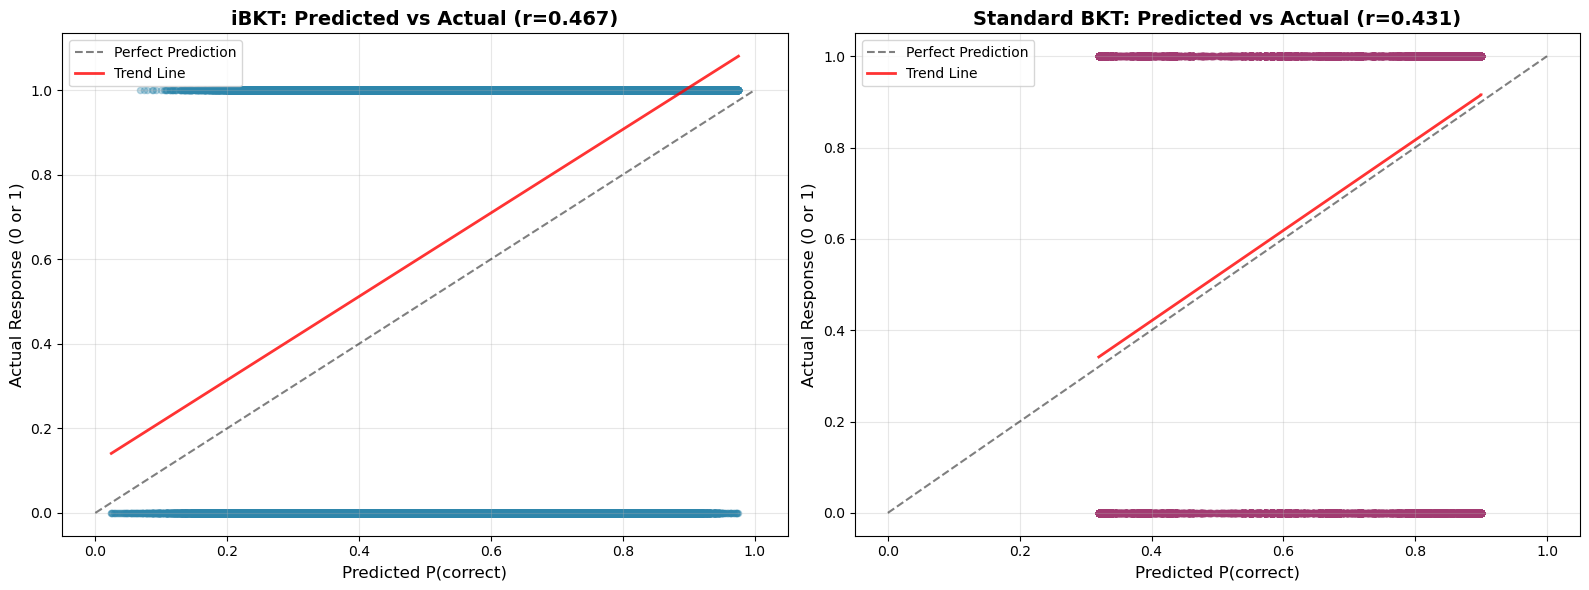

In [40]:
# Scatter plot: Predicted vs Actual with correlation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# iBKT scatter
ax1.scatter(y_pred, y_true, alpha=0.3, s=20, color='#2E86AB')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Prediction')
z = np.polyfit(y_pred, y_true, 1)
p = np.poly1d(z)
ax1.plot(sorted(y_pred), p(sorted(y_pred)), "r-", alpha=0.8, linewidth=2, label=f'Trend Line')
ax1.set_xlabel("Predicted P(correct)", fontsize=12)
ax1.set_ylabel("Actual Response (0 or 1)", fontsize=12)
ax1.set_title(f"iBKT: Predicted vs Actual (r={correlation:.3f})", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.legend()

# BKT scatter
ax2.scatter(bkt_y_pred, bkt_y_true, alpha=0.3, s=20, color='#A23B72')
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Prediction')
z_bkt = np.polyfit(bkt_y_pred, bkt_y_true, 1)
p_bkt = np.poly1d(z_bkt)
ax2.plot(sorted(bkt_y_pred), p_bkt(sorted(bkt_y_pred)), "r-", alpha=0.8, linewidth=2, label=f'Trend Line')
ax2.set_xlabel("Predicted P(correct)", fontsize=12)
ax2.set_ylabel("Actual Response (0 or 1)", fontsize=12)
ax2.set_title(f"Standard BKT: Predicted vs Actual (r={bkt_correlation:.3f})", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()